# Colorectal Cancer Classification and Transfer learning using Pytorch

# Task 1


### Import All Dependencies


In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Define the path to your dataset
#change according to your file directory
data_path = r"./Dataset1/ColorectalCancer"

reason for mean and STD initialization 
check out this discussion: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2



### Data Preprocessing and Loading


Labels: ['MUS', 'NORM', 'STR']
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
(tensor([[[ 0.2111,  0.5193,  1.3927,  ..., -0.0801, -0.2684,  0.0912],
         [-0.2684, -0.1314,  1.3755,  ..., -0.3369, -0.5938, -0.1486],
         [-0.1828,  0.2453,  1.9749,  ...,  0.0056, -0.3198, -0.2513],
         ...,
         [ 0.6221,  0.8618,  1.0673,  ...,  0.9132,  1.4098,  1.3413],
         [ 0.6392,  0.9474,  1.0673,  ...,  1.0159,  1.1187,  1.1700],
         [ 0.5022,  0.8447,  1.1187,  ...,  1.4783,  1.2385,  1.0844]],

        [[-0.4776, -0.2675,  0.4678,  ..., -0.7577, -0.8627, -0.5301],
         [-0.9853, -0.8452,  0.4503,  ..., -0.8277, -1.1604, -0.8978],
         [-0.7927, -0.5301,  0.8004,  ..., -0.6527, -1.0203, -0.9153],
         ...,
         [-0.2150,  0.0301, -0.0049,  ..., -0.1625,  0.2927,  0.2752],
         [-0.3550, -0.0224, -0.0224,  ...,  0.1877,  0.0826,  0.2227],
         [-0.5651, -0.1975, -0.0224,  ...,  0.9055,  0.4153,  0.1352]],


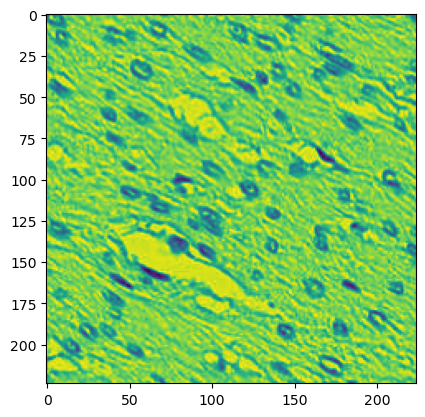

In [2]:
# Transformation pipeline: Resize all images to be of the same size
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize using ImageNet mean and STD
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = dataset.classes  # List of class names inferred from folder names
print(f"Labels: {class_names}")

# Split dataset into training and validation (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get a batch of images and labels
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

#Visualize some pics
image , label = dataset[0]
print(dataset[0])  # Check what this returns

# image = cv2.imread(image)
plt.imshow(image[0])

### Model Definition and Training

In [3]:
# Load the ResNet-18 model with no pre-trained weights
model = models.resnet18()

# Modify the final layer to match the number of classes (3 in this case: MUS, NORM, STR)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Define loss function (Cross-Entropy Loss) and optimizer (SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### Training loop

In [25]:
# Updated train_model function to track loss and accuracy
def train_model(model, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Compute average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        # Disable gradient calculation for validation
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate validation loss and accuracy
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        # Compute average loss and accuracy for validation
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Return model and metrics
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [26]:
# Train the model and collect metrics
model, train_loss, train_acc, val_loss, val_acc = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.0130 Acc: 0.9963
Val Loss: 0.0384 Acc: 0.9900
Epoch 1/9
----------
Train Loss: 0.0092 Acc: 0.9973
Val Loss: 0.0466 Acc: 0.9883
Epoch 2/9
----------
Train Loss: 0.0091 Acc: 0.9971
Val Loss: 0.0524 Acc: 0.9875
Epoch 3/9
----------
Train Loss: 0.0088 Acc: 0.9983
Val Loss: 0.1401 Acc: 0.9542
Epoch 4/9
----------
Train Loss: 0.0144 Acc: 0.9952
Val Loss: 0.0618 Acc: 0.9883
Epoch 5/9
----------
Train Loss: 0.0086 Acc: 0.9981
Val Loss: 0.0391 Acc: 0.9917
Epoch 6/9
----------
Train Loss: 0.0106 Acc: 0.9971
Val Loss: 0.1445 Acc: 0.9558
Epoch 7/9
----------
Train Loss: 0.0137 Acc: 0.9954
Val Loss: 0.0929 Acc: 0.9733
Epoch 8/9
----------
Train Loss: 0.0050 Acc: 0.9992
Val Loss: 0.0373 Acc: 0.9917
Epoch 9/9
----------
Train Loss: 0.0031 Acc: 0.9998
Val Loss: 0.0484 Acc: 0.9892


## Feature Extraction and Visualization

## Plot Training and Validation Losses


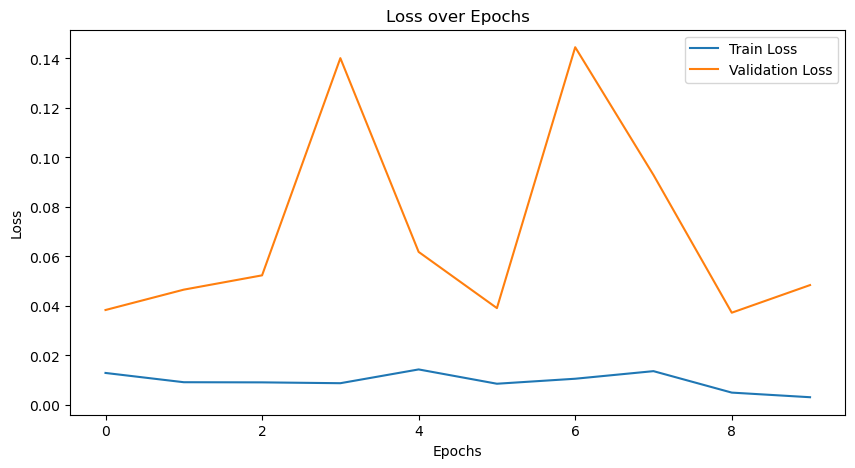

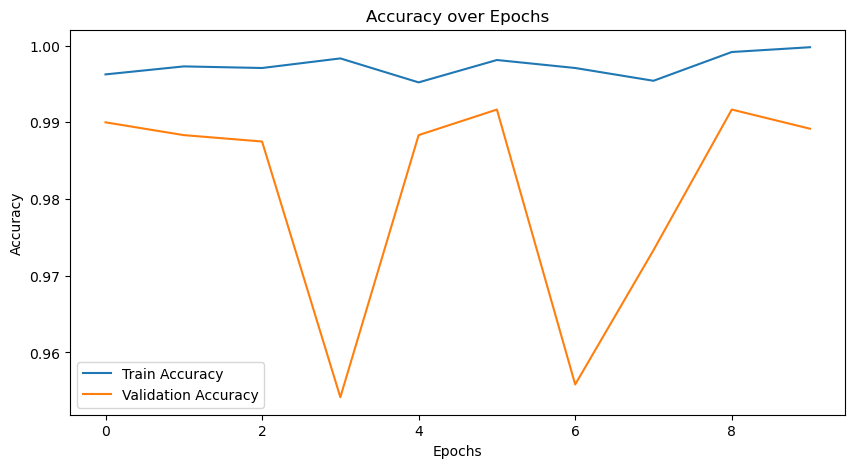

In [27]:
# Plotting loss and accuracy graphs
# Loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

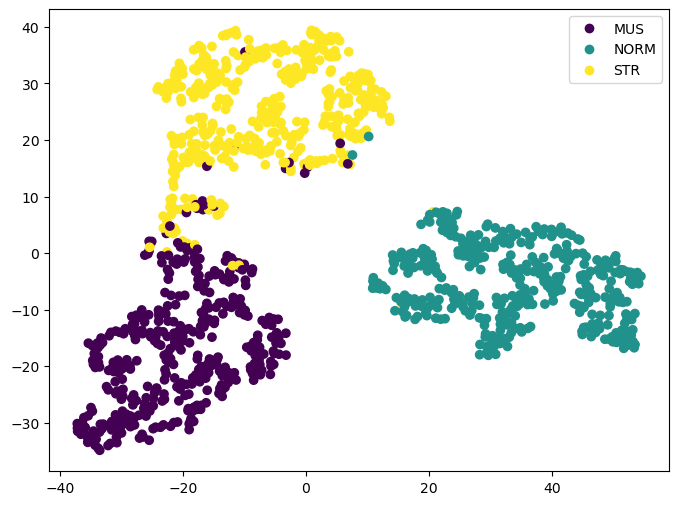

In [6]:
# Function to extract features from the penultimate layer
def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # Get the output from the final layer
            features.append(outputs.cpu().numpy())  # Store the logits
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features from validation dataset
features, labels = extract_features(model, val_loader)

# Perform t-SNE to reduce features to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
plt.show()

# Task 2       Part 2 starts here

## Loading Datasets 2 and 3

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the path to your datasets
data_path_2 = "./Dataset_2"
# /home/eyad/Desktop/projects/colorectal_Cancer_Classification/Task1/Dataset_2
data_path_3 = "./Dataset_3"

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the datasets
dataset_2 = datasets.ImageFolder(root=data_path_2, transform=transform)
dataset_3 = datasets.ImageFolder(root=data_path_3, transform=transform)

# Create DataLoaders
batch_size = 32
loader_2 = DataLoader(dataset_2, batch_size=batch_size, shuffle=False)
loader_3 = DataLoader(dataset_3, batch_size=batch_size, shuffle=False)

# Print class names
class_names_2 = dataset_2.classes
class_names_3 = dataset_3.classes
print(f"Dataset 2 Labels: {class_names_2}")
print(f"Dataset 3 Labels: {class_names_3}")

Dataset 2 Labels: ['Dataset_2']
Dataset 3 Labels: ['Dataset_3']


### Load the Pre-Trained CNN Encoder from Task 1

In [8]:
model_task1 = model
model_task1.eval()

# Remove the classification head
encoder_task1 = nn.Sequential(*list(model_task1.children())[:-1])

### Load a Pre-trained ImageNet CNN Encoder

In [9]:
# Load a pre-trained ResNet-18 model
model_imagenet = models.resnet18(pretrained=True)
# model_imagenet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_imagenet.eval()

# Remove the classification head
encoder_imagenet = nn.Sequential(*list(model_imagenet.children())[:-1])


/home/eyad/anaconda3/envs/venv1/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eyad/anaconda3/envs/venv1/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Comparing Encoder Weights for Similarity

In [10]:
for param_task1, param_imagenet in zip(encoder_task1.parameters(), encoder_imagenet.parameters()):
    if not torch.equal(param_task1.to(device), param_imagenet.to(device)):
        print("The encoders are different.")
        break
else:
    print("The encoders have identical weights.")


The encoders are different.


In [11]:
print(encoder_task1)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [12]:
print(encoder_imagenet)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

### Extract both features using Both encoders

In [13]:
def extract_features(encoder, dataloader, device):
    encoder.to(device)
    encoder.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = encoder(inputs)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten the features
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Extract features for Dataset 2
features_task1_2, labels_2 = extract_features(encoder_task1, loader_2, device)
features_imagenet_2, labels_2 = extract_features(encoder_imagenet, loader_2, device)

# Extract features for Dataset 3
features_task1_3, labels_3 = extract_features(encoder_task1, loader_3, device)
features_imagenet_3, labels_3 = extract_features(encoder_imagenet, loader_3, device)

## Inspecting the Shapes of Extracted Features

In [14]:
print(features_task1_2.shape, features_imagenet_2.shape)
print(features_task1_3.shape, features_imagenet_3.shape)

(6000, 512) (6000, 512)
(6000, 512) (6000, 512)


## Previewing Extracted Feature Values

In [15]:
print(features_task1_2[:5])
print(features_imagenet_2[:5])

[[0.84823376 0.5630708  1.425623   ... 0.36989808 0.82271767 1.2934327 ]
 [0.41125113 0.7052384  1.838873   ... 0.4698283  0.62533486 0.7861609 ]
 [0.6010621  0.5837937  1.6641644  ... 0.3675265  0.5255438  0.95270395]
 [0.6818642  0.3469577  1.5268883  ... 0.31258735 0.8099028  1.0608907 ]
 [0.88309586 0.8884627  1.4712008  ... 0.31255275 1.0547919  0.94801915]]
[[1.3482825  0.21059519 0.         ... 1.2953409  0.02532014 0.47178727]
 [0.3627635  0.04738472 0.         ... 0.6240556  0.         0.50557935]
 [1.1214979  0.1768371  0.03323483 ... 1.2967616  0.11599406 0.30345225]
 [0.42614737 0.06432061 0.07735069 ... 1.4534289  0.22871941 0.5828004 ]
 [0.28758413 0.01275355 0.13293208 ... 1.6829803  0.12766597 0.21928824]]


### Apply t-SNE for Visualization

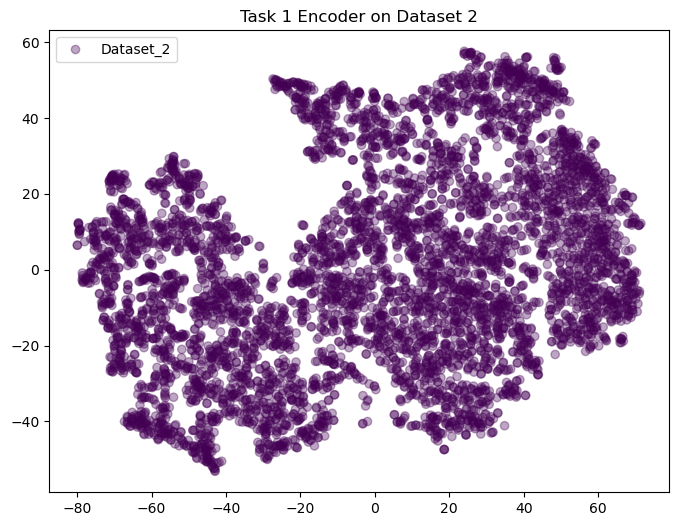

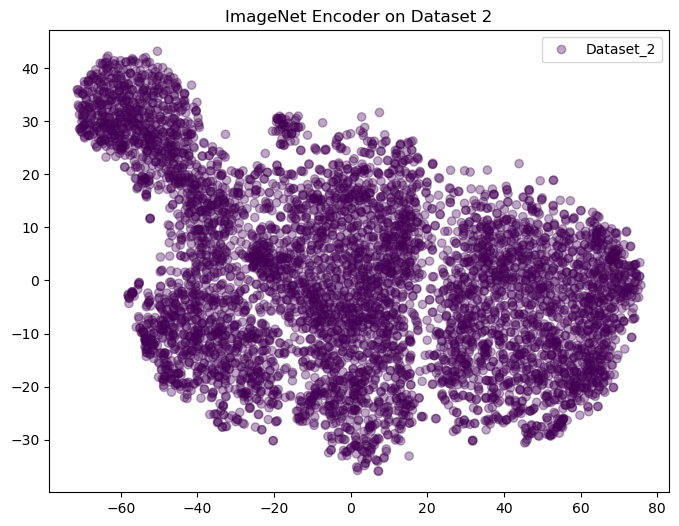

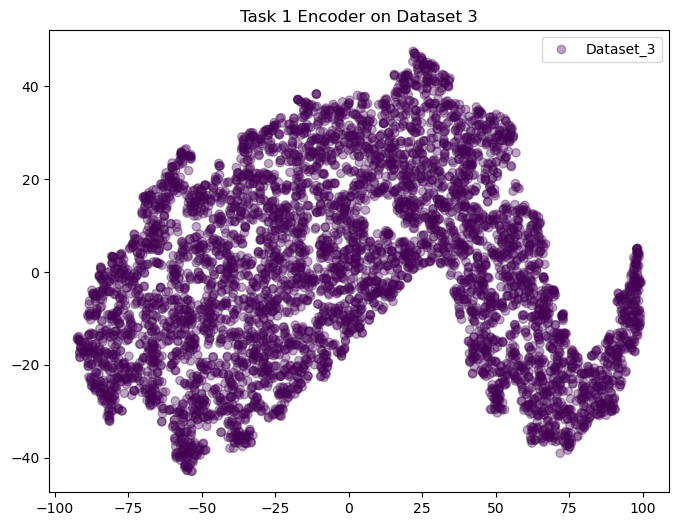

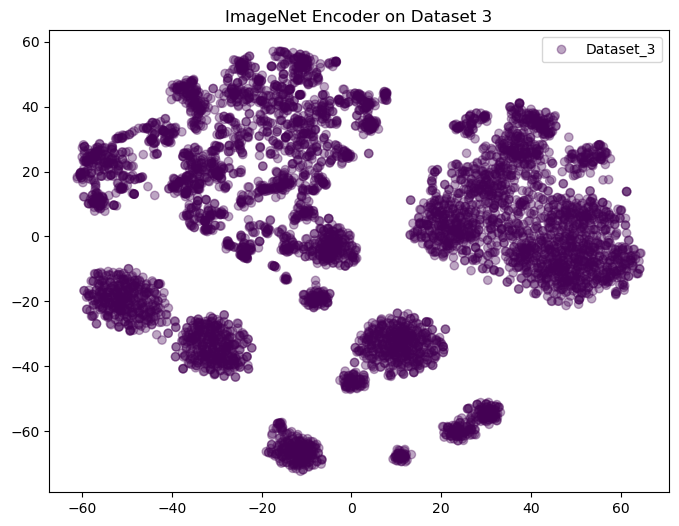

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels, title, class_names):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.35)
    plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
    plt.title(title)
    plt.show()

# Plot t-SNE for Dataset 2
plot_tsne(features_task1_2, labels_2, "Task 1 Encoder on Dataset 2", class_names_2)
plot_tsne(features_imagenet_2, labels_2, "ImageNet Encoder on Dataset 2", class_names_2)

# Plot t-SNE for Dataset 3
plot_tsne(features_task1_3, labels_3, "Task 1 Encoder on Dataset 3", class_names_3)
plot_tsne(features_imagenet_3, labels_3, "ImageNet Encoder on Dataset 3", class_names_3)

### Classify extracted features

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def classify_features(features, labels):
    # Split the data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

# Classify features for Dataset 2 using Task 1 encoder
classify_features(features_imagenet_2, labels_2)

# Classify features for Dataset 3 using ImageNet encoder
classify_features(features_imagenet_3, labels_3)

Accuracy: 1.0000
Classification Report:


ValueError: Number of classes, 1, does not match size of target_names, 3. Try specifying the labels parameter

Alternative could be used not sure yet:


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def classify_features(features, labels):
    # Split the data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Determine unique classes and generate target names
    unique_classes = np.unique(y_test)
    target_names = [f"Class {i}" for i in unique_classes]

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

# Example usage
classify_features(features_imagenet_2, labels_2)
classify_features(features_imagenet_3, labels_3)


In [67]:
def plot_training_curves(features, labels, class_names, title="Training Curves"):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Initialize Random Forest with warm_start=True to add trees incrementally
    clf = RandomForestClassifier(n_estimators=1, warm_start=True, oob_score=True, random_state=42)

    train_accuracies = []
    test_accuracies = []
    oob_accuracies = []

    # Train the model incrementally by adding one tree at a time
    for i in range(1, 101):  # Number of trees
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Calculate train accuracy
        train_pred = clf.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        train_accuracies.append(train_acc)

        # Calculate test accuracy
        test_pred = clf.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)
        test_accuracies.append(test_acc)

        # Calculate OOB accuracy (if available)
        if hasattr(clf, "oob_score_"):
            oob_accuracies.append(clf.oob_score_)
        else:
            oob_accuracies.append(np.nan)

    # Plot the training curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 101), train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(range(1, 101), test_accuracies, label="Testing Accuracy", marker='x')
    if oob_accuracies:
        plt.plot(range(1, 101), oob_accuracies, label="OOB Accuracy", linestyle='--')

    plt.title(title)
    plt.xlabel("Number of Trees")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Classify features for Dataset 2 using Task 1 encoder
classify_features(features_imagenet_2, labels_2, class_names=["Class 1", "Class 2"])

# Classify features for Dataset 3 using ImageNet encoder
classify_features(features_imagenet_3, labels_3, class_names=["Class 1", "Class 2"])

# Plot training curves for Dataset 2
plot_training_curves(features_imagenet_2, labels_2, class_names=["Class 1", "Class 2"], title="Dataset 2 Training Curves")

# Plot training curves for Dataset 3
plot_training_curves(features_imagenet_3, labels_3, class_names=["Class 1", "Class 2"], title="Dataset 3 Training Curves")


TypeError: classify_features() missing 1 required positional argument: 'class_names'

Accuracy: 1.0000
Classification Report:


ValueError: Number of unique classes (1) does not match size of target_names (2).